# Introduction
In this exercise, clustering will be performed on the mall customer data. This is done in order to give advice to the mall owner, so that a marketing design can be created.

In [1]:
# Import the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.vq import whiten
import itertools
import time

In [2]:
# Read the dataset
df = pd.read_csv("Mall_Customers.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# EDA
In this chapter, some Exploratory Data Analysis (EDA) will be performed. To do this, the following actions will be done:
- Renaming the columns
- Converting Male/Female to numeric values
- Checking the distributions of the columns to check for possible outliers
- Normalize the numeric values so that our cluster models will read the data better. 

NOTE: we don't have to deal with null values, because we can see from the info method in the introduction that there are no null values in the data.
## Renaming columns

In [3]:
# Set the columns to rename
cols_rename = ['customer_id', 'gender', 'age', 'annual_income_x1000', 'spending_score']

# Rename the columns and show the data using the info method to
# proof the column names are changed.
df.columns = cols_rename

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customer_id          200 non-null    int64 
 1   gender               200 non-null    object
 2   age                  200 non-null    int64 
 3   annual_income_x1000  200 non-null    int64 
 4   spending_score       200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Convert gender column to 1/0


In [4]:
# Print the unique values to see which values have to be remapped
print(df.gender.unique())

['Male' 'Female']


In [5]:
# Create the mapping to convert Female 
mapping_gender = {'Female': 1, 'Male': 0}

df = df.replace(mapping_gender)

df.head()

,customer_id,gender,age,annual_income_x1000,spending_score
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


## Distribution

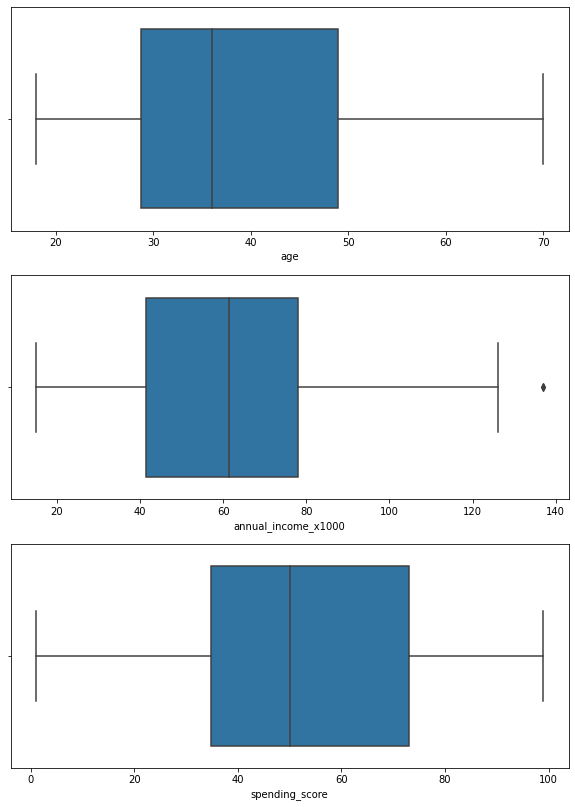

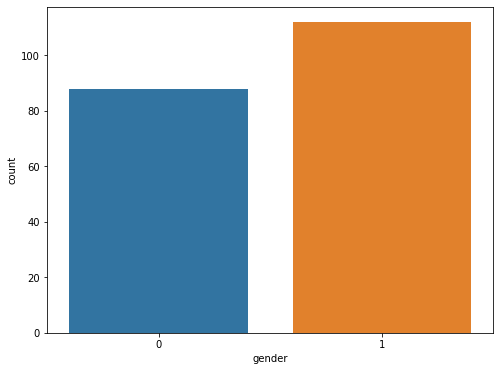

In [6]:
# Create the figure and the axis
fig, axes = plt.subplots(nrows = 3, figsize = (10, 14))

# Select the columns to check the distributions for
cols = ['age', 'annual_income_x1000', 'spending_score']

# Create a box plot for each column in a separate subplot
for col, ax in zip(cols, axes.flat):
    sns.boxplot(x = str(col), data = df, ax = ax)
    
# Create a new figure that shows the distribution of the gender columns using a histogram
plt.figure(figsize=(8, 6))
sns.countplot(x = df.gender)
plt.show()

### Findings
Based on the box plot, we can see that the numeric features are well distributed. Only the `annual_income_x1000` column has one outlier. But the outlier is not too big and doesn't disturb the rest of the data. So, no removal or cleaning is necessary. We're still going to normalize the data to improve our modules.

## Scaling & Normalization

In [7]:
# Use whiten to scale the data
# Select the columns to scale the data to.
cols = ['age', 'gender', 'annual_income_x1000', 'spending_score']

# Use the whiten method to normalize the data into 
df[cols] = whiten(df[cols])

df.head()

,customer_id,gender,age,annual_income_x1000,spending_score
0,1,0.000000,1.363567,0.572541,1.514041
1,2,0.000000,1.507100,0.572541,3.144546
2,3,2.014557,1.435334,0.610711,0.232929
3,4,2.014557,1.650634,0.610711,2.989260
4,5,2.014557,2.224767,0.648880,1.552862


# Clustering
In this chapter, the cluster algorithms will be created and used for our data. We will use Kmeans clustering and hierarchial clustering, train the models and compare the results with each other. After that, some conclusions will be drawn that will serve as input for the marketing owner to create a marketing design.

In [8]:
# Select the columns to use as features for your data
features = df.drop('customer_id', axis = 1)

## KMeans
In this paragraph, the KMeans algorithm will be used for clustering. First the elbowplot will be shown to see which number of clusters suit the model the best. Then, the clustering will be performed. After that, each possible numerical combination will be plotted with the predicted clusters as colours.

In [9]:
# Create the array that serves as input for the elbow plot
inertia = []
n_clusters = range(1, 10)

# For 10 iterations, perform KMeans clustering and extract the Sum of squared 
# distances of samples to their closest cluster center
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(features)
    inertia.append(kmeans.inertia_)

C:\Users\ardejong\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


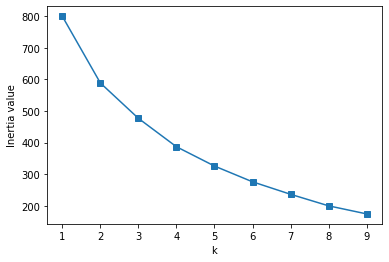

In [10]:
# Plot the elbow plot
plt.plot(n_clusters, inertia, marker='s')
plt.xlabel('k')
plt.ylabel('Inertia value')
plt.show()

### Findings
We can see that the elbow plot didn't really create a sharp angle to find the optimal number of clusters. But for now, it seems that 4 clusters would be the best option for now.

In [11]:
# Extrac the columns and create an array with possible combinations
cols_pairs = ['age', 'annual_income_x1000', 'spending_score']
pairs = list(itertools.combinations(df[cols_pairs], 2))

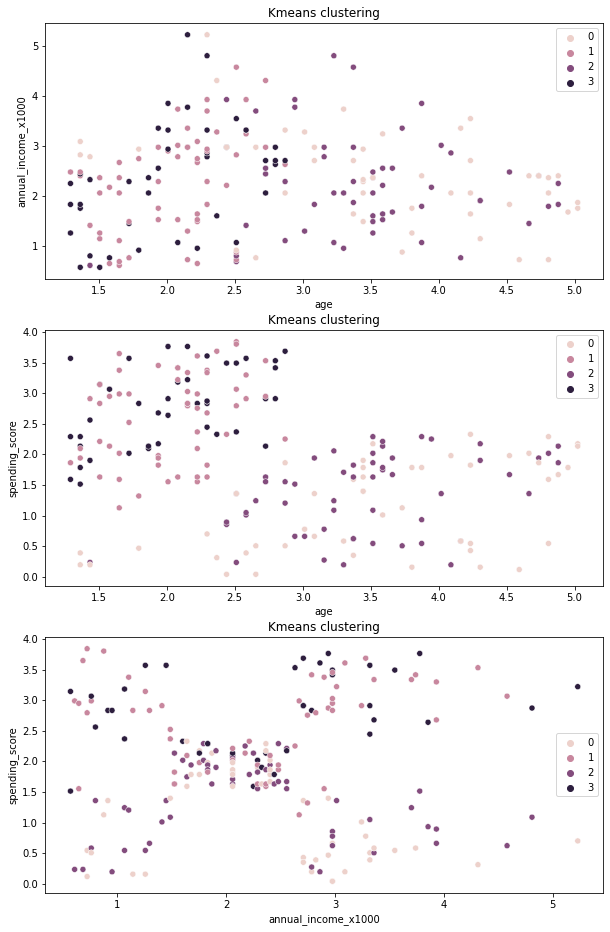

Execution time for KMeans: 1.02595



In [12]:
# Create subplots of kmeans clustering using the pairs list
fig, axes = plt.subplots(nrows = len(pairs), figsize = (10, 16))
start = time.time()
# Create a scatterplot for each combination
for pair, ax in zip(pairs, axes.flat):
    # Extract the pairing to set the x and y labels
    x_label = pair[0]
    y_label = pair[1]
    
    # Fit and predict using 4 clusters
    kmeans_features = KMeans(n_clusters = 4, random_state = 21).fit(features)
    y_kmeans = kmeans_features.predict(features)
    
    # Create a scattplot with hue set to the predicted groups
    sns.scatterplot(x = x_label, y = y_label, data = df, hue=y_kmeans, sizes = 60, ax = ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title("Kmeans clustering")

plt.show()

end = time.time()
print("Execution time for KMeans: {:.5f}\n".format(end - start))

## Hierarchial clustering
In this paragraph, hierarchial clustering wil be performed. At first, a dendogram will be created to select the number of clusters. After that, the clustering will be performed.

NOTE: the method we chose is ward because it's the most effective to deal with noisy data.

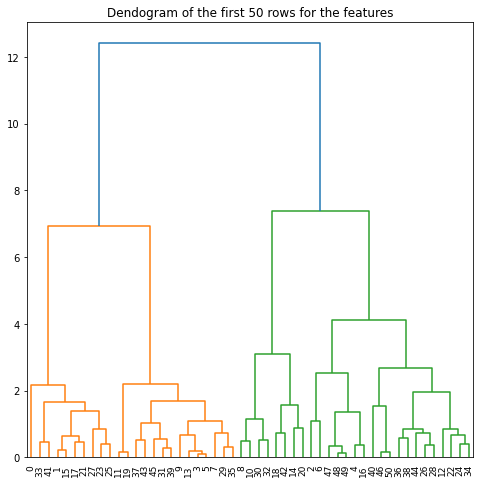

In [13]:
# Create dendogram to check for n_clusters
# Select the first 50 features to have a better overview.
# Choose the centroid method
plt.figure(figsize=(8, 8))
lin = linkage(features.loc[:50,:], method = 'ward')
dendrogram(lin, leaf_font_size=9, leaf_rotation=90)
plt.title('Dendogram of the first 50 rows for the features')
plt.show()

### Findings
Based on the dendrogram, it looks like 4 clusters is the best option if you would set the threshold to 5 or 6. This would create a shorter distance between clusters. 3 clusters would also be an option, but for now, we'll use 4 clusters.

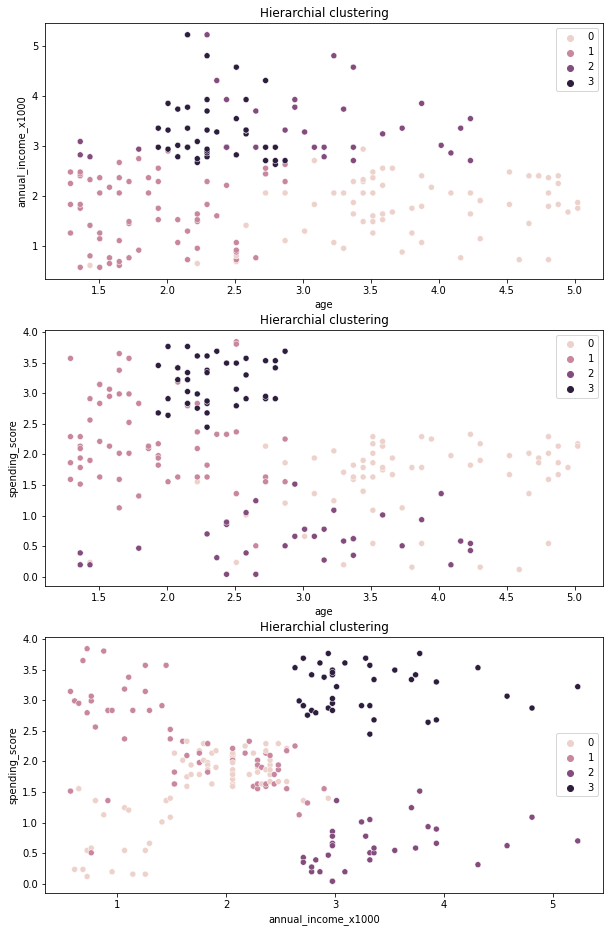

Execution time for Hierarchial: 0.55426



In [14]:
# Create subplots of hierarchial clustering using the pairs list
fig, axes = plt.subplots(nrows = len(pairs), figsize = (10, 16))

start = time.time()
for pair, ax in zip(pairs, axes.flat):
    x_label = pair[0]
    y_label = pair[1]
    
    hier_clust = AgglomerativeClustering(n_clusters=4, 
                                              affinity='euclidean', linkage='ward').fit(features)
    labels = hier_clust.labels_
    sns.scatterplot(x = x_label, y = y_label, data = df, hue=labels, sizes = 60, ax = ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title("Hierarchial clustering")
    
plt.show()
end = time.time()
print("Execution time for Hierarchial: {:.5f}\n".format(end - start))

### Findings
Overall, it seems that Hierarchial clustering performs better on the data. KMeans has more overlapping groups. Futhermore, Hierarchial clustering performs a bit faster.

# Conclusion
Based on the clustering algorithms, we can see a couple of important distinctions between the groups:
- Group 0: high age, low income, low spending score
- Group 1: low income, mid-low age, high spending score.
- Group 2: high income, low spending score, mid-high age
- Group 3: high income, high spending score. Relatively young.

It looks like that group 2 has a high income, yet low spending score. This means that there's potential to increase their spending score. It would advice to investigate which type of products group 2 buys (e.g. using a survey) and offer those products more. You can also offer more products that are more targeted towards their mid-high age, such as household appliances or clothes for mid-age people

The second advice, would be based on group 1: low income, mid-low age, high spending score. This indicates a possible tread, because this group has a high spending score, yet low income. When the income becomes even lower, the spending score could drop. That's why, it's important to keep them using discount for the products that they buy.

Group 3 has a high income and high spending score. So there isn't much potential to increase that, other than to keep the offers to them the same.

Group 1 also doesn't have much potential, given the low income and low spending score. You could increase the spending score by offering them relative high discounts in order to increase their spending score.